In [12]:
import Pkg; 
Pkg.add("Turing")
Pkg.add("MCMCChains")

   Resolving package versions...
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`
Precompiling project...
  ✓ LogDensityProblemsAD → LogDensityProblemsADForwardDiffBenchmarkToolsExt
  ✓ DynamicPPL → DynamicPPLEnzymeCoreExt
  2 dependencies successfully precompiled in 11 seconds. 529 already precompiled.
   Resolving package versions...
    Updating `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  [c7f686f2] + MCMCChains v6.0.6
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`


In [177]:
using Turing, MCMCChains
using XLSX
using DataFrames, TimeSeries
using StatsPlots
include("utils.jl")

print_percentiles (generic function with 1 method)

In [201]:
data = DataFrame(XLSX.readtable("assets_data_03.24.xlsx", "Indexes_PLN";infer_eltypes=true))
data = TimeArray(data[!,[:Date, :ACWI_Net_PLN]],timestamp=:Date)
returns = percentchange(data,:log)
returns = from(returns, Date(2020,01,01))
returns_summarystats(returns,1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
ACWI_Net_PLN,0.0404168,0.105947,0.00877042,0.0293867,-0.0926707,-0.110526,-0.00571891,-0.1279,0.457972,0.216999,0.013036


In [212]:
struct GibsSamplerGBM
    returns::Vector{Float64}
    returns_mu::Float64
    T::Int
    n_iter::Int
    mu_dist::Vector{Float64}
    sigma_dist::Vector{Float64}

    function GibsSamplerGBM(returns::Vector{Float64}, init_sigma::Float64, n_iter::Int=10000)
        new(returns, mean(returns), length(returns), n_iter, zeros(n_iter + 1), [init_sigma; zeros(n_iter)])
    end
end

function normal(sampler::GibsSamplerGBM, sigma2::Float64)
    dist = Normal(sampler.returns_mu, sqrt(sigma2 / sampler.T))
    return rand(dist)
end

function inv_gamma(sampler::GibsSamplerGBM, mu::Float64)
    B = 0.5 * sum((sampler.returns .- mu).^2)
    a = sampler.T / 2 + 1
    mean = B / (a - 1)
    dist = InverseGamma(a, B)
    return sqrt(rand(dist))
end



function run!(sampler::GibsSamplerGBM)
    for i in 2:sampler.n_iter
        sampler.mu_dist[i] = normal(sampler, sampler.sigma_dist[i-1]^2)
        sampler.sigma_dist[i] = inv_gamma(sampler, sampler.mu_dist[i])
    end
end




run! (generic function with 2 methods)

In [189]:
module Spike

using StatsBase
using Distributions

struct GibsSamplerGBM2
    returns::Vector{Float64}
    returns_mu::Float64
    T::Int
    n_iter::Int    
    sigma_prior_var::Float64
    mu_dist::Vector{Float64}
    sigma_dist::Vector{Float64}
    

    function GibsSamplerGBM2(returns::Vector{Float64}, n_iter::Int=10000)
        mu = mean(returns)
        B = 0.5 * sum((returns .- mu).^2)
        new(returns, mu, length(returns), n_iter, B, zeros(n_iter), zeros(n_iter))
    end
end

function normal(sampler::Spike.GibsSamplerGBM2, sigma::Float64)
    dist = Normal(sampler.returns_mu, sigma^2 / sampler.T)
    return rand(dist)
end

function inv_gamma(sampler::Spike.GibsSamplerGBM2)    
    a = (sampler.T -1) / 2 
    dist = InverseGamma(a, sampler.sigma_prior_var)
    return sqrt(rand(dist))
end


function run!(sampler::Spike.GibsSamplerGBM2)
    for i in 1:sampler.n_iter
        sampler.sigma_dist[i] = inv_gamma(sampler)
        sampler.mu_dist[i] = normal(sampler, sampler.sigma_dist[i])
    end
end

end

Main.Spike

In [213]:
model = Spike.GibsSamplerGBM(values(returns),10000)
Spike.run!(model)

UndefVarError: UndefVarError: `GibsSamplerGBM` not defined

In [203]:
describe(model.mu_dist)

Summary Stats:
Length:         10000
Missing Count:  0
Mean:           0.008770
Std. Deviation: 0.000034
Minimum:        0.008614
1st Quartile:   0.008749
Median:         0.008771
3rd Quartile:   0.008792
Maximum:        0.008960
Type:           Float64


In [204]:
# * 12^.5
describe(model.sigma_dist) 

Summary Stats:
Length:         10000
Missing Count:  0
Mean:           0.041093
Std. Deviation: 0.004210
Minimum:        0.028606
1st Quartile:   0.038151
Median:         0.040705
3rd Quartile:   0.043672
Maximum:        0.062085
Type:           Float64


In [205]:
module Spike2
# d samples per one posterior
using Distributions

function simulate(model, n_steps, d = 4)
    n_posterior_sample = length(model.mu_dist)
 
    result = zeros(n_posterior_sample*d,n_steps)

    for i in 1:n_posterior_sample
        sample = rand(Normal(model.mu_dist[i],model.sigma_dist[i]^2),d,n_steps)
        n = i*d-d+1
        result[n:n+d-1,:] = sample
    end

    return result

end

end

scenarios = Spike2.simulate(model, 60, 10)

100000×60 Matrix{Float64}:
 0.00876856  0.00933158  0.00813185  …  0.00970054  0.00847151  0.0104198
 0.00974377  0.00816026  0.00994567     0.0100439   0.00758409  0.00850304
 0.00972937  0.00747167  0.00712865     0.00865295  0.00949256  0.00909673
 0.00923688  0.00929899  0.00739637     0.0101606   0.00880462  0.00943373
 0.0082067   0.0087871   0.00898554     0.00828641  0.00974316  0.00791982
 0.0097361   0.0109552   0.00973119  …  0.00764407  0.00865715  0.00894588
 0.00939237  0.00947228  0.00759712     0.0102234   0.00889901  0.00657058
 0.0064614   0.0103369   0.00918292     0.0096448   0.00903613  0.00780605
 0.00894544  0.0103354   0.00692786     0.0103962   0.00956935  0.0103668
 0.0105773   0.0089329   0.0101504      0.0102226   0.0101429   0.0106489
 ⋮                                   ⋱                          
 0.00856829  0.00867751  0.00837139     0.01144     0.00992633  0.00768055
 0.0110681   0.00981153  0.0100269      0.009884    0.00881703  0.0102469
 0.00724337 

In [208]:
scen_ann = annualise(scenarios,12)
describe(scen_ann[:,1])

Summary Stats:
Length:         100000
Missing Count:  0
Mean:           0.105262
Std. Deviation: 0.006052
Minimum:        0.063431
1st Quartile:   0.101399
Median:         0.105288
3rd Quartile:   0.109160
Maximum:        0.140496
Type:           Float64


In [209]:
print_percentiles(scen_ann,[.01,0.05,0.25,0.5,0.75,0.95,0.99])

,1,2,3,4,5
0.01,0.0904191,0.0905518,0.0904543,0.0904917,0.0904097
0.05,0.0953856,0.0953958,0.0953023,0.0953485,0.0952716
0.25,0.101399,0.101361,0.101339,0.101366,0.101346
0.5,0.105288,0.10526,0.105212,0.105226,0.105213
0.75,0.10916,0.109135,0.109123,0.109098,0.109119
0.95,0.115105,0.1151,0.11517,0.115131,0.115132
0.99,0.119923,0.120073,0.120027,0.120179,0.119899


In [199]:
print_percentiles(scen_ann,[.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0.0,-0.000935495,-0.00134338,-0.00183982,-0.00261015,-0.00205879,-0.00147716,-0.00143618,-0.00150507,-0.0010423,-0.00126674,-0.00109502,-0.00257229,-0.00123712,-0.00146111,-0.001422,-0.00106084,-0.00148178,-0.00146883,-0.00127193,-0.00141636,-0.00129235,-0.000942321,-0.00132539,-0.00179724,-0.00113513,-0.00119266,-0.00194055,-0.00104203,-0.00132695,-0.00164177,-0.00100807,-0.000932926,-0.00157051,-0.00196667,-0.00187463,-0.00153506,-0.00144794,-0.00188432,-0.00209116,-0.00100189,-0.00155154,-0.00173259,-0.00206631,-0.00195261,-0.00132753,-0.00133354,-0.00152312,-0.00097855,-0.00118818,-0.00127545,-0.00159472,-0.00123182,-0.00148946,-0.00161829,-0.000896437,-0.00157687,-0.00146676,-0.00198853,-0.00144045,-0.000983577
0.1,0.00322119,0.00321398,0.00321202,0.00322638,0.00324142,0.00322525,0.00322578,0.00320812,0.00321782,0.00322966,0.0032229,0.00323357,0.00321578,0.00322867,0.00322978,0.00322033,0.00323284,0.00323814,0.00322726,0.00322014,0.00322381,0.00322027,0.00321465,0.00320345,0.00323063,0.00321301,0.00321983,0.00323125,0.0032283,0.00321678,0.00322465,0.00322164,0.00322778,0.00322339,0.00321354,0.00321877,0.00321221,0.00322804,0.00322977,0.00321385,0.00323045,0.00322623,0.00320369,0.00322064,0.00323415,0.00323097,0.00321749,0.00322457,0.0032248,0.00320565,0.00322289,0.00322568,0.00323407,0.00322906,0.00322801,0.0032304,0.0032306,0.00322015,0.00321682,0.00322495
0.2,0.00383904,0.00383892,0.00383682,0.00384687,0.00385023,0.00385406,0.00385021,0.00383329,0.00384276,0.00384921,0.00385161,0.00384968,0.0038514,0.00384988,0.00385386,0.00384014,0.00384747,0.00385778,0.00383607,0.00384611,0.0038392,0.00384973,0.00383424,0.00383576,0.00385156,0.00384479,0.00383834,0.0038526,0.00384213,0.00383308,0.00384397,0.00384023,0.00385314,0.00385167,0.00384076,0.00383688,0.00383768,0.00384841,0.003849,0.00383874,0.00383914,0.00383852,0.00382417,0.00383773,0.00384438,0.00385077,0.00384594,0.00384506,0.00384468,0.00383481,0.00384362,0.00384577,0.00384991,0.0038468,0.00384185,0.00385065,0.00385101,0.00384228,0.00384756,0.00384624
0.3,0.00428797,0.00428298,0.00428062,0.00428775,0.0042978,0.00429632,0.00429499,0.00428201,0.00429123,0.00429755,0.00429751,0.00429403,0.00429638,0.00428853,0.0042958,0.00429174,0.00428288,0.0042981,0.0042837,0.00429193,0.00428569,0.00429316,0.00428582,0.00428483,0.0042928,0.00429099,0.00428706,0.00429923,0.00428396,0.00428144,0.0042846,0.00429054,0.00429447,0.00430105,0.00428284,0.00428032,0.0042766,0.00429675,0.00429479,0.00427881,0.00428538,0.00428132,0.00427619,0.00428926,0.00429261,0.0042884,0.00429018,0.00428392,0.00429256,0.00427825,0.00429088,0.00428837,0.00429277,0.00429593,0.00428241,0.00429014,0.00429103,0.00428325,0.00429453,0.00428696
0.4,0.00466684,0.0046625,0.0046645,0.00465993,0.00466824,0.0046736,0.00466831,0.00465758,0.00466854,0.00466824,0.00467545,0.00467073,0.00467493,0.00466902,0.00467096,0.00466564,0.0046662,0.00467489,0.0046589,0.00466913,0.00466345,0.00466746,0.00466574,0.004666,0.00467385,0.0046717,0.00466638,0.00467699,0.00465961,0.00466299,0.00466239,0.00466089,0.0046729,0.00467669,0.00465885,0.00466436,0.00466325,0.00467681,0.0046688,0.00465958,0.00465703,0.00465847,0.00465828,0.00466683,0.00466902,0.00466342,0.00466848,0.00466421,0.00466563,0.00464959,0.00466608,0.00466492,0.00466814,0.00467168,0.00466063,0.00466862,0.00466719,0.0046624,0.00467308,0.00466478
0.5,0.00501848,0.00502359,0.00502219,0.00501785,0.00502609,0.00503132,0.0050238,0.00501581,0.00502531,0.00502747,0.00502948,0.00502206,0.00502934,0.00502493,0.00502605,0.00501835,0.00502309,0.00502906,0.0050155,0.00502695,0.00501767,0.00502099,0.00501554,0.00501712,0.00502627,0.00502319,0.00501865,0.00503295,0.00500976,0.00501855,0.00501749,0.00501686,0.00502122,0.00502601,0.0050135,0.00501843,0.00502003,0.00503103,0.00502508,0.00501122,0.00501196,0.00501099,0.00501428,0.

In [171]:
scenarios = rand(Normal(0.0089, 0.0390),(10000,60))
scen_ann = annualise(scenarios,12)
print_percentiles(scen_ann, [0.05, 0.25, 0.5, 0.75, 0.95])

,1,2,3,4,5
0.05,-0.11642,-0.119271,-0.116733,-0.115491,-0.111212
0.25,0.0164954,0.0184444,0.018485,0.0150041,0.015225
0.5,0.10526,0.108461,0.107189,0.109131,0.108527
0.75,0.195095,0.19904,0.197365,0.198768,0.197163
0.95,0.325879,0.332589,0.32745,0.332085,0.329262


In [172]:
print_percentiles(scen_ann,[.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0])

,1,2,3,4,5
0.0,-0.387656,-0.435721,-0.384116,-0.44701,-0.406207
0.1,-0.0663035,-0.0648307,-0.0663257,-0.0670977,-0.0660511
0.2,-0.00648156,-0.00441845,-0.00553229,-0.00738295,-0.00705323
0.3,0.0354392,0.0381742,0.0385069,0.0359898,0.0347985
0.4,0.0711988,0.0757612,0.0734027,0.0740783,0.0733248
0.5,0.10526,0.108461,0.107189,0.109131,0.108527
0.6,0.138475,0.141742,0.141571,0.142921,0.141717
0.7,0.174326,0.179254,0.177328,0.179323,0.178513
0.8,0.218256,0.222361,0.218659,0.222266,0.218941
0.9,0.277356,0.282856,0.279667,0.281861,0.278735


In [214]:
describe(sampler.mu_dist.*12)

Summary Stats:
Length:         3001
Missing Count:  0
Mean:           0.107387
Std. Deviation: 0.053653
Minimum:        -0.090570
1st Quartile:   0.071871
Median:         0.107532
3rd Quartile:   0.142715
Maximum:        0.316973
Type:           Float64


In [215]:
describe(sampler.sigma_dist*12^0.5)

Summary Stats:
Length:         3001
Missing Count:  0
Mean:           0.134452
Std. Deviation: 0.011110
Minimum:        0.000000
1st Quartile:   0.127011
Median:         0.133641
3rd Quartile:   0.141156
Maximum:        0.179803
Type:           Float64


In [15]:
0.07 / 12

0.005833333333333334

In [216]:
@model function GBM(y)

    mu ~ Normal(0.0058,0.02)
    sigma ~ InverseGamma(0.04)
       
    return y ~ Normal(mu,sigma)

end

GBM (generic function with 2 methods)

In [224]:
model = GBM(values(returns))
chain = sample(model, NUTS(0.65), 10_000)

Sampling   0%|█                                         |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.037500000000000006
└ @ Turing.Inference C:\Users\matsz\.julia\packages\Turing\duwEY\src\mcmc\hmc.jl:212
Sampling   0%|█                                         |  ETA: 0:00:02
Sampling   1%|█                                         |  ETA: 0:00:02
Sampling   2%|█                                         |  ETA: 0:00:02
Sampling   2%|█                                         |  ETA: 0:00:02
Sampling   2%|██                                        |  ETA: 0:00:02
Sampling   3%|██                                        |  ETA: 0:00:02
Sampling   4%|██                                        |  ETA: 0:00:02
Sampling   4%|██                                        |  ETA: 0:00:02
Sampling   4%|██                                        |  ETA: 0:00:02
Sampling   5%|███                                       |  ETA: 0:00:02
Sampling   6%|███                                       |  ETA: 0:

Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.94 seconds
Compute duration  = 1.94 seconds
parameters        = mu, sigma
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse     ess_bulk    ess_tail      rhat  ⋯
      Symbol   Float64   Float64   Float64      Float64     Float64   Float64  ⋯

          mu    0.0087    0.0052    0.0000   10991.5499   7473.2631    1.0001  ⋯
       sigma    0.0469    0.0043    0.0000    8998.8345   6698.5447    1.0000  ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

  

In [194]:
0.0073 *12

0.0876

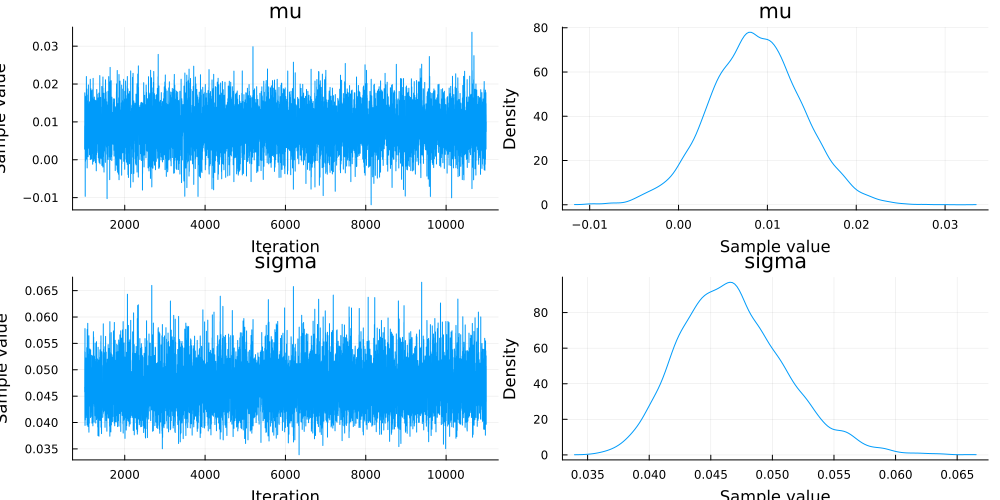

In [218]:
plot(chain)

In [219]:
describe(chain)[1]


Summary Statistics
  parameters      mean       std      mcse     ess_bulk    ess_tail      rhat  ⋯
      Symbol   Float64   Float64   Float64      Float64     Float64   Float64  ⋯

          mu    0.0087    0.0052    0.0001   10260.0920   7410.1236    1.0000  ⋯
       sigma    0.0468    0.0043    0.0000    8753.2069   6974.1120    0.9999  ⋯
                                                                1 column omitted


In [220]:
describe(chain)[2]

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          mu   -0.0016    0.0052    0.0086    0.0121    0.0188
       sigma    0.0393    0.0437    0.0464    0.0494    0.0562


In [208]:
[0.0058, 0.0073, 0.0089] .* 12

3-element Vector{Float64}:
 0.0696
 0.0876
 0.1068

In [226]:
n_scenarios = 10000
n_steps = 120
scenarios = zeros(n_scenarios,n_steps)

params = get(chain,[:mu, :sigma])

for s in 1:n_scenarios
    scenarios[s,:] = rand(Normal(params.mu[s], params.sigma[s]),n_steps)
end

scen_ann = annualise(scenarios,12)

print_percentiles(scen_ann,[0.05, 0.25, 0.5, 0.75, 0.95])

,1,2,3,4,5,6,7,8,9,10
0.05,-0.188557,-0.178264,-0.182505,-0.186221,-0.18374,-0.181008,-0.185739,-0.185339,-0.185192,-0.17963
0.25,-0.0127065,-0.0102556,-0.0123078,-0.0117364,-0.011827,-0.0107418,-0.0147811,-0.0111677,-0.010981,-0.0127424
0.5,0.10515,0.102996,0.106243,0.105234,0.104439,0.102891,0.102107,0.103257,0.10527,0.104721
0.75,0.221357,0.221184,0.224493,0.222571,0.223977,0.220248,0.22232,0.220056,0.222879,0.22123
0.95,0.392493,0.39065,0.392273,0.387178,0.393123,0.387892,0.392796,0.392784,0.395503,0.3952


In [139]:
scenarios = rand(Normal(0.0089, 0.0390),(n_scenarios,n_steps))
scen_ann = annualise(scenarios,12)
print_percentiles(scen_ann, [0.05, 0.25, 0.5, 0.75, 0.95])

UndefVarError: UndefVarError: `n_scenarios` not defined

In [120]:
using LinearAlgebra
cor = [1 0.9 0.9; 0.9 1 0.9; 0.9 .9 1]

3×3 Matrix{Float64}:
 1.0  0.9  0.9
 0.9  1.0  0.9
 0.9  0.9  1.0

In [121]:
cholesky(cor).L

3×3 LowerTriangular{Float64, Matrix{Float64}}:
 1.0   ⋅         ⋅ 
 0.9  0.43589    ⋅ 
 0.9  0.206474  0.383886

In [123]:
cholesky([1 .9; .9 1]).L

2×2 LowerTriangular{Float64, Matrix{Float64}}:
 1.0   ⋅ 
 0.9  0.43589

In [73]:
sig = [0.05 0.06]

1×2 Matrix{Float64}:
 0.05  0.06

In [78]:
cov = cor2cov(cor,sig)

2×2 Matrix{Float64}:
 0.0025   0.00285
 0.00285  0.0036

In [79]:
chol = cholesky(cov).L

2×2 LowerTriangular{Float64, Matrix{Float64}}:
 0.05    ⋅ 
 0.057  0.018735

In [98]:
z = [1.213, 0.453]

2-element Vector{Float64}:
 1.213
 0.453

In [107]:
round.(chol * z; digits=4)

2-element Vector{Float64}:
 0.0607
 0.0776

In [236]:
dot([1 2; 3 4], [1 2;1 2])

16

In [233]:
[1 2; 3 4] * [1, 2]

2-element Vector{Int64}:
  5
 11

In [88]:
sum([1 2; 3 4] .* [1 2], dims=2)

2×1 Matrix{Int64}:
  5
 11

In [95]:
[1 2; 3 4] * [1, 2]

2-element Vector{Int64}:
  5
 11